<a href="https://colab.research.google.com/github/ramalias/urban-expansion/blob/main/main-urban-expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
#install library if needed

!pip install rasterio geopandas shapely fiona pyproj
!apt-get install -y gdal-bin
!gdalinfo --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 65.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.

In [28]:
#import library

import os
import rasterio, json
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import subprocess
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask as rasterio_mask  # Alias the mask function
from rasterio.enums import Resampling
from shapely.geometry import mapping
from rasterio.enums import Resampling
import pandas as pd
from rasterio.windows import from_bounds

In [4]:
#create main project folder
#run one time only

project_root = '/content/drive/MyDrive/project/urban-exansion'
os.makedirs(project_root, exist_ok=True)

#create folder inside project folder
os.makedirs(os.path.join(project_root, 'data'), exist_ok=True)

print('Workspace created at:', project_root)

Workspace created at: /content/drive/MyDrive/project/urban-exansion


### Folder

In [5]:
#define sentinel folder
SENTINEL_DIR_2019 = "/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix"
Save_dir = os.path.join(SENTINEL_DIR_2019, "subset_grid")
os.makedirs(Save_dir, exist_ok=True)

#define sentinel folder
SENTINEL_DIR_2024 = "/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix"
Save_dir = os.path.join(SENTINEL_DIR_2024, "subset_grid")
os.makedirs(Save_dir, exist_ok=True)


## Unzip the Data (once)

### unzip sentinel data

In [ ]:
dataset_base_dir = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'

files = {
    "2019": os.path.join(dataset_base_dir, "S2B_MSIL2A_20190604T020659.zip"),
    "2024": os.path.join(dataset_base_dir, "S2A_MSIL2A_20240612T020701.zip")
}

extracted_dir = os.path.join(dataset_base_dir, 'unzipped')
os.makedirs(extracted_dir, exist_ok=True)

In [ ]:
for year, path in files.items():
    year_dir = os.path.join(extracted_dir, year)
    os.makedirs(year_dir, exist_ok=True)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(year_dir)
    print(f"Extracted {year} data to: {year_dir}")

Extracted 2019 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019
Extracted 2024 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2024


In [ ]:
def find_bands(year_dir):
    band_files = {}

    for band in ['B02', 'B03', 'B04', 'B08', 'B11']:

        if band in ['B11']:
            pattern = f"{year_dir}/**/*{band}_20m.jp2"
        else:
            pattern = f"{year_dir}/**/*{band}_10m.jp2"

        matches = glob.glob(pattern, recursive=True)
        if matches:
            band_files[band] = matches[0]
        else:
            print(f"⚠️ {band} not found in {year_dir}")

    return band_files


bands_2019 = find_bands(os.path.join(extracted_dir, "2019"))
bands_2024 = find_bands(os.path.join(extracted_dir, "2024"))

print("2019 Bands:", bands_2019)
print("2024 Bands:", bands_2024)


2019 Bands: {'B02': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B02_10m.jp2', 'B03': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B03_10m.jp2', 'B04': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B04_10m.jp2', 'B08': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190

### unzip land cover data

In [ ]:
landcover_base_dir  ='/content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input'

landcover_years = ["2019", "2024"]

extracted_base = os.path.join(landcover_base_dir, "unzipped")
os.makedirs(extracted_base, exist_ok=True)

for year in landcover_years:
    year_folder = os.path.join(landcover_base_dir, year)
    output_folder = os.path.join(extracted_base, year)
    os.makedirs(output_folder, exist_ok=True)

    # Find all zip files in that folder
    zip_files = [f for f in os.listdir(year_folder) if f.endswith('.zip')]
    print(f"Found {len(zip_files)} zip files in {year_folder}")

    for zip_name in zip_files:
        zip_path = os.path.join(year_folder, zip_name)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_folder)

    print(f"Extracted all {year} land cover data to: {output_folder}")

Found 326 zip files in /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/2019
Extracted all 2019 land cover data to: /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/2019
Found 326 zip files in /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/2024
Extracted all 2024 land cover data to: /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/2024


## Convert JP2 to Tiff (once)

In [ ]:
# === Sentinel input folders ===
sentinel_2019 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/S2B_MSIL2A_20190604T020659'
sentinel_2024 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/S2A_MSIL2A_20240612T020701'

# === Output folders ===
output_base = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'
output_2019 = os.path.join(output_base, 'tif2019')
output_2024 = os.path.join(output_base, 'tif2024')
os.makedirs(output_2019, exist_ok=True)
os.makedirs(output_2024, exist_ok=True)

# === Bands to extract ===
targets = ["B02", "B03", "B04", "B08", "B11"]

# === Helper function ===
def convert_sentinel_data(input_dir, output_dir, year):
    print(f"Processing {year} data...")
    for b in targets:
        # search recursively inside all subfolders (including IMG_DATA)
        pattern = os.path.join(input_dir, "**", f"*{b}*.jp2")
        src_files = sorted(glob.glob(pattern, recursive=True))

        if not src_files:
            print(f"No file found for band {b} in {year}")
            continue

        for src in src_files:
            # Keep relative path to prevent filename conflicts
            rel_path = os.path.relpath(src, input_dir).replace("/", "_")
            dst_name = rel_path.replace(".jp2", ".tif")
            dst = os.path.join(output_dir, dst_name)

            cmd = [
                "gdal_translate", "-of", "COG",
                "-co", "COMPRESS=LZW", "-co", "NUM_THREADS=ALL_CPUS",
                src, dst
            ]
            print(f"Converting [{year}] → {os.path.basename(src)}")
            subprocess.run(cmd, check=True)

    print(f"Finished converting {year}. Files saved in: {output_dir}")

# === Run conversion for both years ===
convert_sentinel_data(sentinel_2019, output_2019, 2019)
convert_sentinel_data(sentinel_2024, output_2024, 2024)

print("All conversions complete!")

Processing 2019 data...
Converting [2019] → T52SDE_20190604T020659_B02_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B02_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B02_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B08_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B11_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B11_60m.jp2
Finished converting 2019. Files saved in: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019
Processing 2024 data...
Converting [2024] → T52SDE_20240612T020701_B02_10m.jp2
Converting [2024] → T52SDE_20240612T020701_B02_20m.jp2
Converting [2024] → T52SDE_20240612T020701_B02_60m.jp2
Conver

# Data Preprocessing

## Check the resolution

### 2019

In [ ]:
def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR_2019, pattern))
    return files[0] if files else None

bands_2019 = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands_2019["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (10980, 10980)
CRS: EPSG:32652
Bounds BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


In [18]:
#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

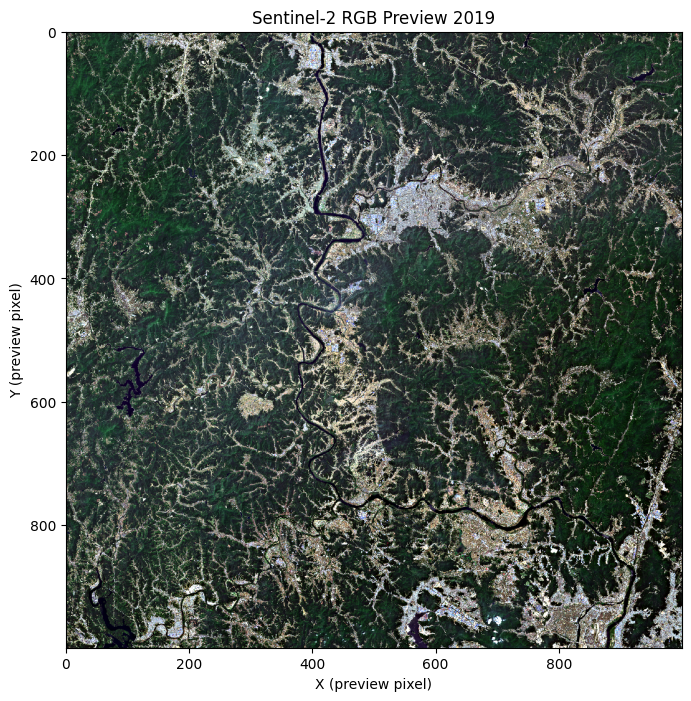

In [ ]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2019["B04"]) as r: R2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019["B03"]) as r: G2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019["B02"]) as r: B2019 = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2019), qstretch(G2019), qstretch(B2019)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2019")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2019/Sentinel2_preview_2019",
            dpi=300, bbox_inches='tight')
plt.show()

### 2024

In [ ]:
def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR_2024, pattern))
    return files[0] if files else None

bands_2024 = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands_2024["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (10980, 10980)
CRS: EPSG:32652
Bounds BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


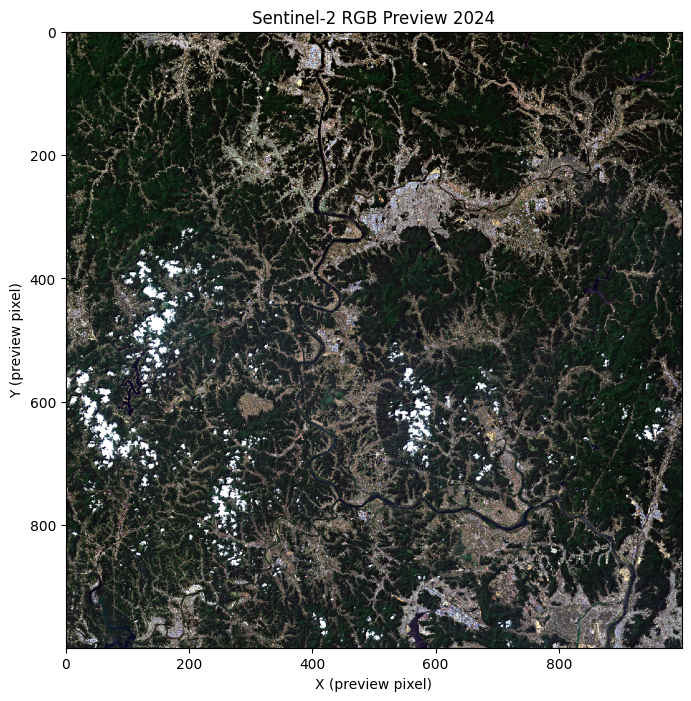

In [ ]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2024["B04"]) as r: R2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024["B03"]) as r: G2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024["B02"]) as r: B2024 = r.read(1, out_shape=(scale, scale))

#Merge into RGB image
rgb = np.dstack([qstretch(R2024), qstretch(G2024), qstretch(B2024)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2024")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2024/Sentinel2_preview_2024",
            dpi=300, bbox_inches='tight')
plt.show()

### Administrative Boundaries

In [ ]:
gadm_path = '/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/boundary daegu/daegu_boundary.shp'
gdf = gpd.read_file(gadm_path)
print("=== GADM Boundary Info ===")
print("CRS:", gdf.crs)
print("Number of Polygons:", len(gdf))
print(gdf.head())

=== GADM Boundary Info ===
CRS: EPSG:4326
Number of Polygons: 1
     GID_1 GID_0      COUNTRY NAME_1                         VARNAME_1  \
0  KOR.4_1   KOR  South Korea  Daegu  Taegu|Daegu Gwang'yeogsi|Taegu-g   

       NL_NAME_1       TYPE_1          ENGTYPE_1 CC_1 HASC_1  ISO_1  \
0  대구광역시 | 大邱廣域市  Gwangyeoksi  Metropolitan City   NA  KR.TG  KR-27   

                                            geometry  
0  POLYGON ((128.45745 35.63956, 128.45743 35.639...  


## Reprojection



sentinel raster info : EPSG:32652
GADM CRS before :  EPSG:4326
GADM CRS after :  PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


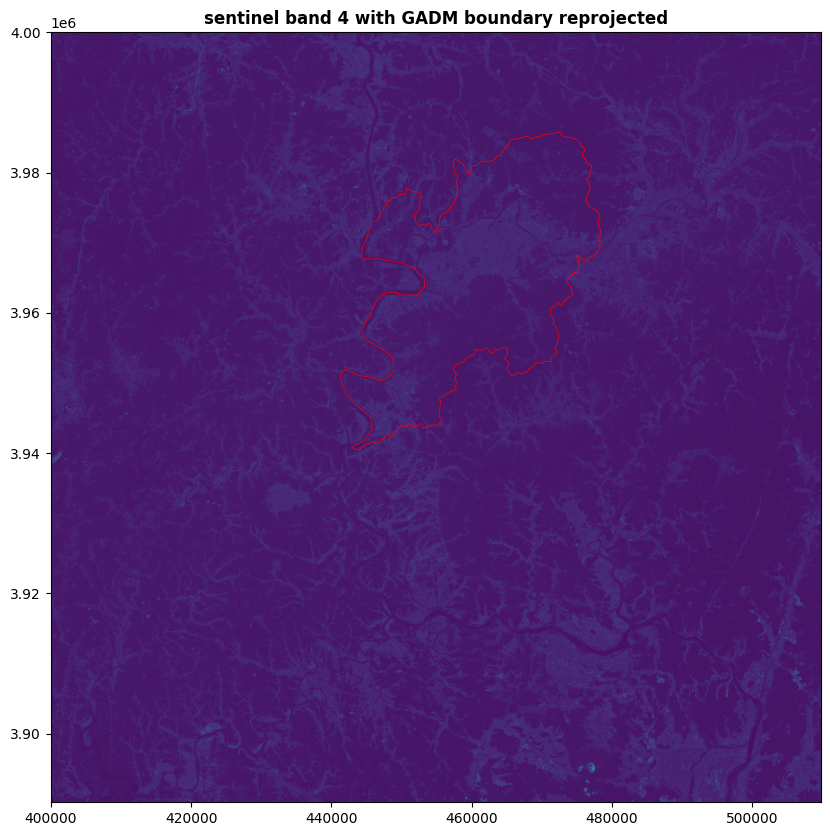

In [ ]:
#file path
raster_path = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix/R10m_T52SDE_20190604T020659_B04_10m.tif'

#open raster
raster = rasterio.open(raster_path)
print('sentinel raster info :', raster.crs)
#GADM city boundary
print('GADM CRS before : ', gdf.crs)

#Reproject GADM to match the sentinel CRS
gadm_reproject = gdf.to_crs(raster.crs)
print('GADM CRS after : ', gadm_reproject.crs)

#save the reproject
gadm_reproject.to_file('/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/daegu_boundary_reproject.shp')

#plot
fig, ax = plt.subplots(figsize=(10,10))
show(raster, ax=ax, title='sentinel band 4 with GADM boundary reprojected')
gadm_reproject.boundary.plot(ax=ax, color='red', linewidth=0.5)
plt.show()

## Clip and Masking

In [ ]:
#reprojected daegu boundary
daegu_boundary = '/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/daegu_boundary_reproject.shp'

### 2019

In [ ]:
#path
clipped_output_dir = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019'
os.makedirs(clipped_output_dir, exist_ok=True)

# Load the reprojected Daegu boundary and get its geometries
d_boundary = gpd.read_file(daegu_boundary)
geom = [mapping(d_boundary.geometry.squeeze())]

#list sentinel tiff
band_files = [f for f in os.listdir(SENTINEL_DIR_2019) if f.endswith('.tif')]
print('found bands:', band_files)

#loop through each band
for band in band_files:
  in_path = os.path.join(SENTINEL_DIR_2019, band)
  out_path = os.path.join(clipped_output_dir, band.replace('.tif', '_clipped.tif'))

  with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio_mask(src,geom, crop=True) # Use aliased function
    out_meta = src.meta.copy()
    out_meta.update({
        'height': out_image.shape[1],
        'width': out_image.shape[2], # Corrected from 'weight' to 'width'
        'transform': out_transform
    })

    with rasterio.open(out_path, 'w', **out_meta) as dest:
      dest.write(out_image)
    print(f'clipped {band} -> saved to {out_path}')

found bands: ['R10m_T52SDE_20190604T020659_B02_10m.tif', 'R10m_T52SDE_20190604T020659_B03_10m.tif', 'R10m_T52SDE_20190604T020659_B04_10m.tif', 'R10m_T52SDE_20190604T020659_B08_10m.tif', 'R20m_T52SDE_20190604T020659_B11_20m.tif']
clipped R10m_T52SDE_20190604T020659_B02_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B02_10m_clipped.tif
clipped R10m_T52SDE_20190604T020659_B03_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B03_10m_clipped.tif
clipped R10m_T52SDE_20190604T020659_B04_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B04_10m_clipped.tif
clipped R10m_T52SDE_20190604T020659_B08_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B08_10m_clipped.tif
clipped R20m_T52SDE_20190604T020659_B11_20m.tif -> 

### 2024

In [ ]:
#path
clipped_output_dir = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024'
os.makedirs(clipped_output_dir, exist_ok=True)

# Load the reprojected Daegu boundary and get its geometries
d_boundary = gpd.read_file(daegu_boundary)
geom = [mapping(d_boundary.geometry.squeeze())]

#list sentinel tiff
band_files = [f for f in os.listdir(SENTINEL_DIR_2024) if f.endswith('.tif')]
print('found bands:', band_files)

#loop through each band
for band in band_files:
  in_path = os.path.join(SENTINEL_DIR_2024, band)
  out_path = os.path.join(clipped_output_dir, band.replace('.tif', '_clipped.tif'))

  with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio_mask(src,geom, crop=True, filled=True)
    out_meta = src.meta.copy()
    out_meta.update({
        'height': out_image.shape[1],
        'width': out_image.shape[2], # Corrected from 'weight' to 'width'
        'transform': out_transform
    })

    with rasterio.open(out_path, 'w', **out_meta) as dest:
      dest.write(out_image)
    print(f'clipped {band} -> saved to {out_path}')

found bands: ['R10m_T52SDE_20240612T020701_B02_10m.tif', 'R10m_T52SDE_20240612T020701_B03_10m.tif', 'R10m_T52SDE_20240612T020701_B04_10m.tif', 'R10m_T52SDE_20240612T020701_B08_10m.tif', 'R20m_T52SDE_20240612T020701_B11_20m.tif']
clipped R10m_T52SDE_20240612T020701_B02_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B02_10m_clipped.tif
clipped R10m_T52SDE_20240612T020701_B03_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B03_10m_clipped.tif
clipped R10m_T52SDE_20240612T020701_B04_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B04_10m_clipped.tif
clipped R10m_T52SDE_20240612T020701_B08_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B08_10m_clipped.tif
clipped R20m_T52SDE_20240612T020701_B11_20m.tif -> 

### Check clipped data

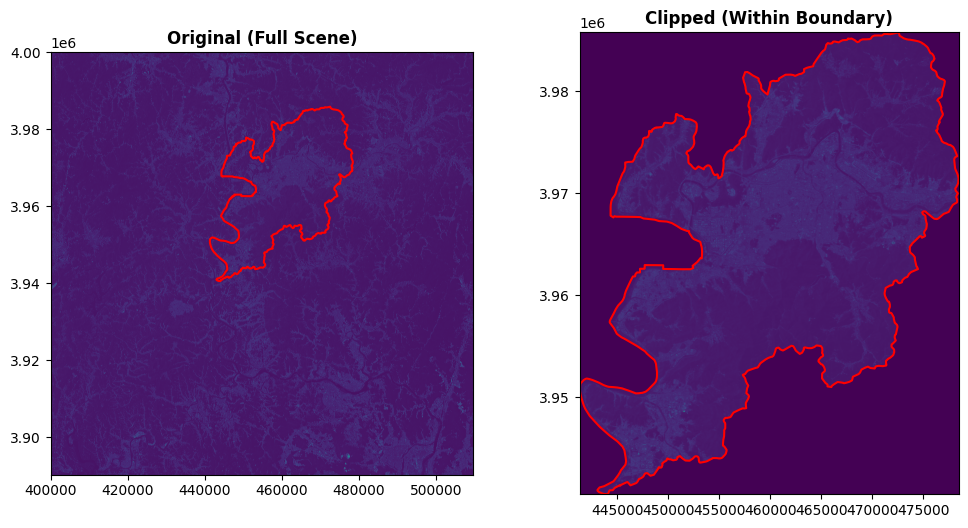

In [ ]:
#path
clipped_path = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B04_10m_clipped.tif'
original_path = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix/R10m_T52SDE_20190604T020659_B04_10m.tif'
boundary_path = '/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/daegu_boundary_reproject.shp'

#load
orig = rasterio.open(original_path)
clipped = rasterio.open(clipped_path)
boundary = gpd.read_file(boundary_path)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
show(orig, ax=ax1, title="Original (Full Scene)")
d_boundary.boundary.plot(ax=ax1, color='red')
show(clipped, ax=ax2, title="Clipped (Within Boundary)")
d_boundary.boundary.plot(ax=ax2, color='red')
plt.show()

In [ ]:
print("Original bounds:", orig.bounds)
print("Clipped bounds :", clipped.bounds)
print("Original shape (rows, cols):", (orig.height, orig.width))
print("Clipped shape (rows, cols):", (clipped.height, clipped.width))

Original bounds: BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Clipped bounds : BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Original shape (rows, cols): (10980, 10980)
Clipped shape (rows, cols): (4531, 3714)


In [ ]:
print("Raster CRS:", clipped.crs)
print("Boundary CRS:", d_boundary.crs)

Raster CRS: EPSG:32652
Boundary CRS: EPSG:32652


In [ ]:
# Band to resample (example: B11)
band_to_resample = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R20m_T52SDE_20240612T020701_B11_20m_clipped.tif'
output_resampled = '/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m.tif'

# Read reference
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height
    ref_crs = ref.crs

# Resample 20m → 10m
with rasterio.open(band_to_resample) as src:
    data = src.read(
        out_shape=(src.count, ref_height, ref_width),
        resampling=Resampling.bilinear
    )
    new_meta = src.meta.copy()
    new_meta.update({
        "height": ref_height,
        "width": ref_width,
        "transform": ref_transform,
        "crs": ref_crs
    })
    with rasterio.open(output_resampled, "w", **new_meta) as dst:
        dst.write(data)

print(f"Resampled {os.path.basename(band_to_resample)} to 10m")

Resampled R20m_T52SDE_20240612T020701_B11_20m_clipped.tif to 10m


### Preview clipped RGB data

### Folder

In [ ]:
clipped_2019_dir = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019'
clipped_2024_dir = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024'

### 2019

In [ ]:
def find_first(pattern):
    files = glob.glob(os.path.join(clipped_2019_dir, pattern))
    return files[0] if files else None

bands_2019_clipped = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands_2019_clipped["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (4531, 3714)
CRS: EPSG:32652
Bounds BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|


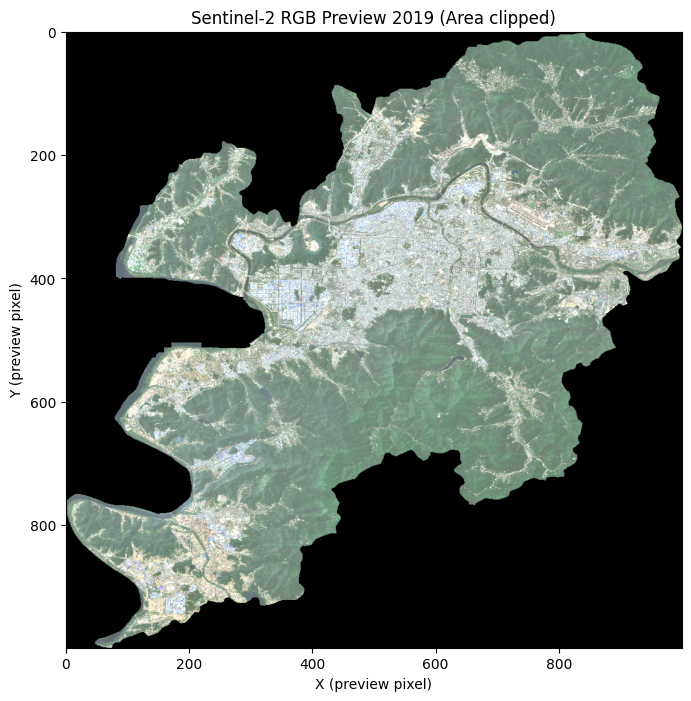

In [ ]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2019_clipped["B04"]) as r: R2019_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019_clipped["B03"]) as r: G2019_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019_clipped["B02"]) as r: B2019_c = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2019_c), qstretch(G2019_c), qstretch(B2019_c)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2019 (Area clipped)")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2019/Sentinel2_preview_2019_clipped",
            dpi=300, bbox_inches='tight')
plt.show()

### 2024

In [ ]:
def find_first(pattern):
    files = glob.glob(os.path.join(clipped_2024_dir, pattern))
    return files[0] if files else None

bands_2024_clipped = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands_2024_clipped["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (4531, 3714)
CRS: EPSG:32652
Bounds BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|


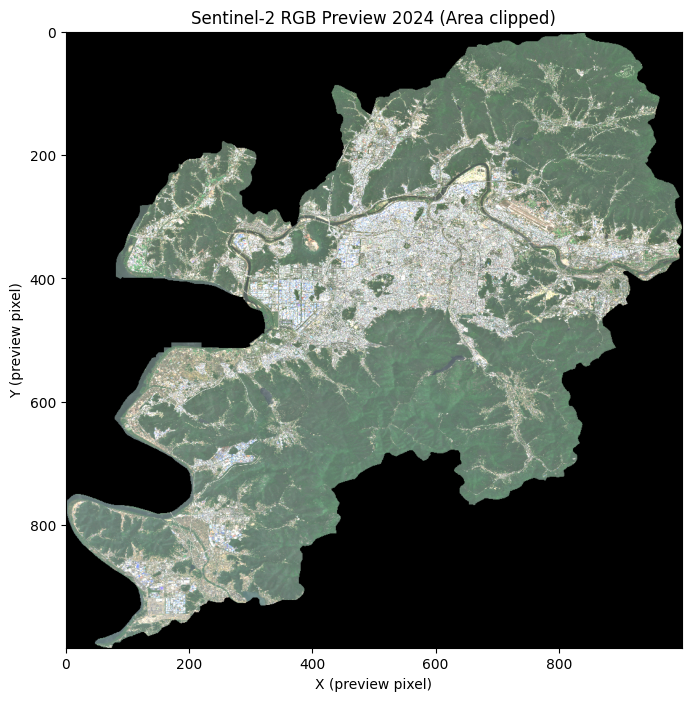

In [ ]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2024_clipped["B04"]) as r: R2024_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024_clipped["B03"]) as r: G2024_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024_clipped["B02"]) as r: B2024_c = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2024_c), qstretch(G2024_c), qstretch(B2024_c)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2024 (Area clipped)")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2024/Sentinel2_preview_2024_clipped",
            dpi=300, bbox_inches='tight')
plt.show()

## Resampling B11 (20 to 10)

### 2019

In [ ]:
# Reference 10m band (use Red: B04)
ref_path = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B04_10m_clipped.tif'

# Band to resample (example: B11)
band_to_resample = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R20m_T52SDE_20190604T020659_B11_20m_clipped.tif'
output_resampled = "/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m_2019.tif"

os.makedirs("/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/", exist_ok=True)

# Read reference
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height
    ref_crs = ref.crs

# Resample 20m → 10m
with rasterio.open(band_to_resample) as src:
    data = src.read(
        out_shape=(src.count, ref_height, ref_width),
        resampling=Resampling.bilinear
    )
    new_meta = src.meta.copy()
    new_meta.update({
        "height": ref_height,
        "width": ref_width,
        "transform": ref_transform,
        "crs": ref_crs
    })
    with rasterio.open(output_resampled, "w", **new_meta) as dst:
        dst.write(data)

print(f"Resampled {os.path.basename(band_to_resample)} to 10m")


Resampled R20m_T52SDE_20190604T020659_B11_20m_clipped.tif to 10m


### 2024

In [ ]:
# Reference 10m band (use Red: B04)
ref_path = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B04_10m_clipped.tif'

# Band to resample (example: B11)
band_to_resample = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R20m_T52SDE_20240612T020701_B11_20m_clipped.tif'
output_resampled = '/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m_2024.tif'

os.makedirs("/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/", exist_ok=True)

# Read reference
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height
    ref_crs = ref.crs

# Resample 20m → 10m
with rasterio.open(band_to_resample) as src:
    data = src.read(
        out_shape=(src.count, ref_height, ref_width),
        resampling=Resampling.bilinear
    )
    new_meta = src.meta.copy()
    new_meta.update({
        "height": ref_height,
        "width": ref_width,
        "transform": ref_transform,
        "crs": ref_crs
    })
    with rasterio.open(output_resampled, "w", **new_meta) as dst:
        dst.write(data)

print(f"Resampled {os.path.basename(band_to_resample)} to 10m")


Resampled R20m_T52SDE_20240612T020701_B11_20m_clipped.tif to 10m


### Check

In [ ]:
# read resampled data
B11_masking_2019 = rasterio.open('/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m_2019.tif')
B11_masking_2024 = rasterio.open('/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m_2024.tif')

print("B11 2019 masked data bounds:", B11_masking_2019.bounds)
print("B11 2024 masked data bounds:", B11_masking_2024.bounds)
print("B11 2019 masked data shape (rows, cols):", (B11_masking_2019.height, B11_masking_2019.width))
print("B11 2024 masked data shape (rows, cols):", (B11_masking_2024.height, B11_masking_2024.width))
print("B11 2019 masked data bounds:", B11_masking_2019.crs)
print("B11 2024 masked data bounds:", B11_masking_2024.crs)

B11 2019 masked data bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
B11 2024 masked data bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
B11 2019 masked data shape (rows, cols): (4531, 3714)
B11 2024 masked data shape (rows, cols): (4531, 3714)
B11 2019 masked data bounds: EPSG:32652
B11 2024 masked data bounds: EPSG:32652


## Pre processing land cover data

### Merge land cover data

In [ ]:
# Base directories
base_dir = '/content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped'
years = ['2019', '2024']

merged_output_dir = os.path.join(base_dir, 'merged')
os.makedirs(merged_output_dir, exist_ok=True)

for year in years:
    year_path = os.path.join(base_dir, year)
    shapefiles = glob.glob(os.path.join(year_path, '**', '*.shp'), recursive=True)
    print(f"Found {len(shapefiles)} shapefiles in {year} folder")

    # Merge all shapefiles into one GeoDataFrame
    # Only proceed if shapefiles are found
    if shapefiles:
        gdfs = [gpd.read_file(shp) for shp in shapefiles]
        merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

        output_path = os.path.join(merged_output_dir, f"Daegu_landcover_{year}_merged.shp")
        merged.to_file(output_path, encoding='utf-8')
        print(f"Merged {year} shapefiles saved to: {output_path}")
    else:
        print(f"No shapefiles to merge for {year}.")


Found 326 shapefiles in 2019 folder


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(


Merged 2019 shapefiles saved to: /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/merged/Daegu_landcover_2019_merged.shp
Found 326 shapefiles in 2024 folder
Merged 2024 shapefiles saved to: /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/merged/Daegu_landcover_2024_merged.shp


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(


In [ ]:
merged_dir = '/content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/merged'

# Load both merged shapefiles
gdf_2019 = gpd.read_file(os.path.join(merged_dir, 'Daegu_landcover_2019_merged.shp'))
gdf_2024 = gpd.read_file(os.path.join(merged_dir, 'Daegu_landcover_2024_merged.shp'))

# Print basic info
print("2019:", len(gdf_2019), "features")
print("2024:", len(gdf_2024), "features")

# Check CRS
print("2019 CRS:", gdf_2019.crs)
print("2024 CRS:", gdf_2024.crs)

# Check unique data L1
print("\n2019 L1_NAME classes:", gdf_2019['L1_NAME'].unique())
print("2024 L1_NAME classes:", gdf_2024['L1_NAME'].unique())

# Check unique data in L3
print("\n2019 L3_NAME classes:", gdf_2019['L3_NAME'].unique())
print("2024 L3_NAME classes:", gdf_2024['L3_NAME'].unique())

2019: 332700 features
2024: 923467 features
2019 CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["ITRF2000",DATUM["International_Terrestrial_Reference_Frame_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6656"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2024 CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["ITRF2000",DATUM["International_Terrestrial_Reference_Frame_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6656"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_east

### Reproject land cover

In [ ]:
# Reproject both to match Sentinel CRS (EPSG:32652)
sentinel_crs = "EPSG:32652"
gdf_2019_utm = gdf_2019.to_crs(sentinel_crs)
gdf_2024_utm = gdf_2024.to_crs(sentinel_crs)

# Save reprojected shapefiles
output_dir = os.path.join(merged_dir, "reprojected")
os.makedirs(output_dir, exist_ok=True)

gdf_2019_utm.to_file(os.path.join(output_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024_utm.to_file(os.path.join(output_dir, 'Daegu_landcover_2024_reprojected.shp'))

print("Reprojection complete, Saved in:", output_dir)

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(


Reprojection complete, Saved in: /content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/merged/reprojected


In [ ]:
# Your folder containing the reprojected shapefiles
reprojected_lc_dir = '/content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/merged/reprojected'

gdf_2019 = gpd.read_file(os.path.join(output_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024 = gpd.read_file(os.path.join(output_dir, 'Daegu_landcover_2024_reprojected.shp'))

print("2019 features:", len(gdf_2019))
print("2024 features:", len(gdf_2024))
print("CRS:", gdf_2019.crs)
print(gdf_2019.columns)

2019 features: 332700
2024 features: 923467
CRS: EPSG:32652
Index(['L1_CODE', 'L1_NAME', 'L2_CODE', 'L2_NAME', 'L3_CODE', 'L3_NAME',
       'IMG_NAME', 'IMG_DATE', 'LU_INFO', 'ETC_INFO', 'ENV_INFO', 'FOR_INFO',
       'UD_INFO', 'INX_NUM', 'geometry'],
      dtype='object')


### Visualize

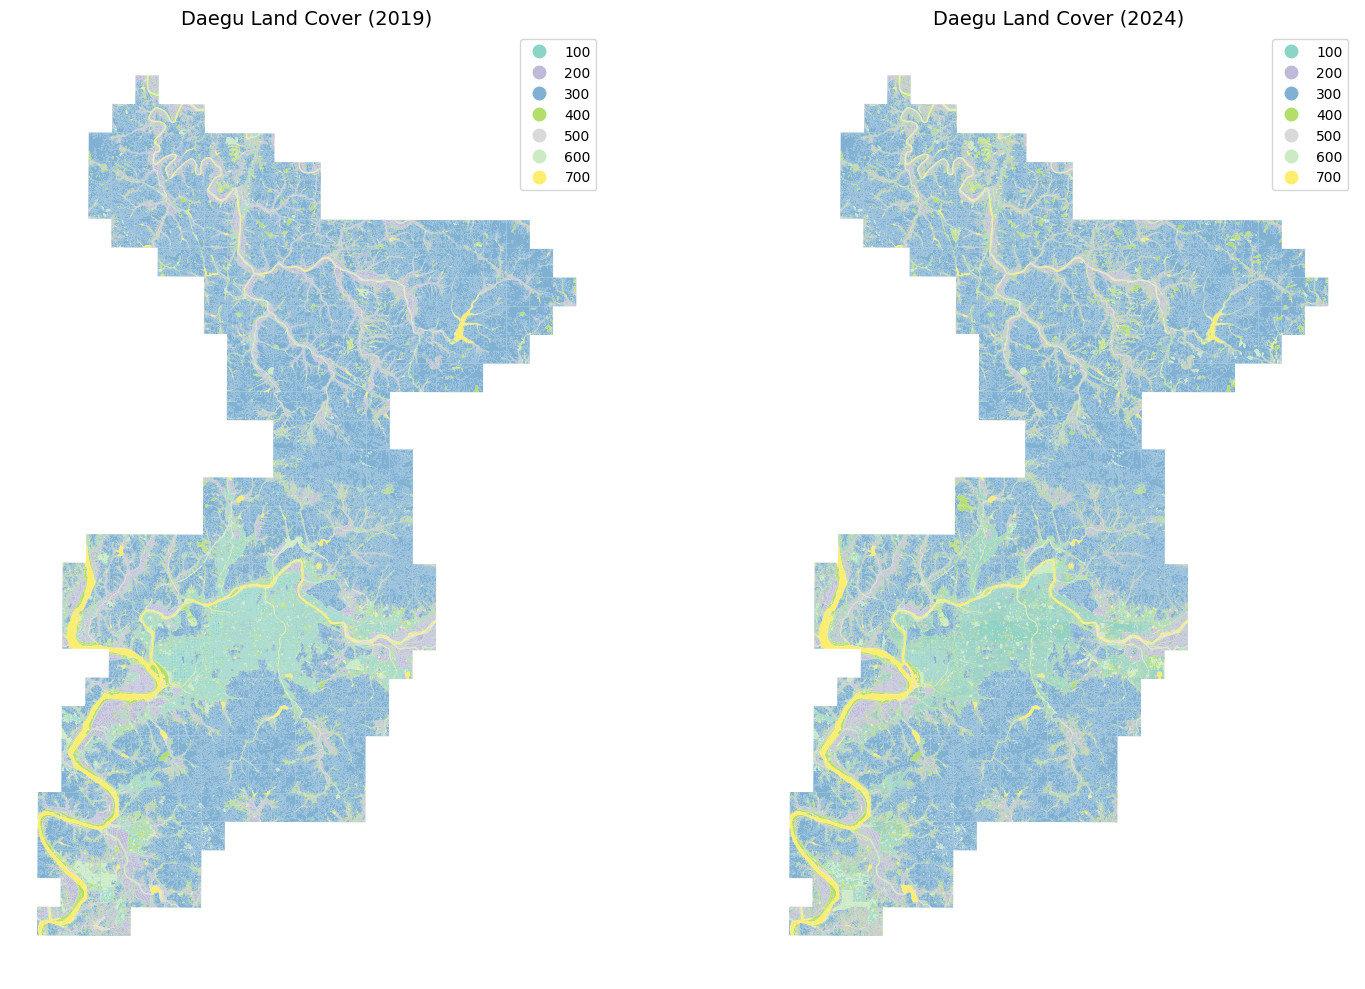

In [9]:
merged_dir = '/content/drive/MyDrive/project/urban-exansion/data/06_land_cover_data/input/unzipped/merged/reprojected'

# Load both merged shapefiles
gdf_2019_f = gpd.read_file(os.path.join(merged_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024_f = gpd.read_file(os.path.join(merged_dir, 'Daegu_landcover_2024_reprojected.shp'))

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

# Plot 2019
gdf_2019_f.plot(column='L1_CODE', categorical=True, legend=True, cmap='Set3', ax=ax[0])
ax[0].set_title('Daegu Land Cover (2019)', fontsize=14)
ax[0].axis('off')

# Plot 2024
gdf_2024_f.plot(column='L1_CODE', categorical=True, legend=True, cmap='Set3', ax=ax[1])
ax[1].set_title('Daegu Land Cover (2024)', fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()


/tmp/ipython-input-128252463.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipython-input-128252463.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


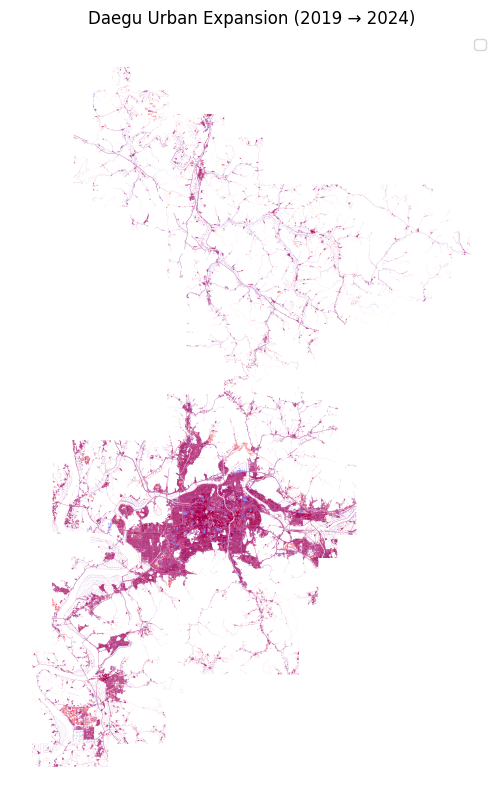

In [10]:
urban_2019 = gdf_2019_f[gdf_2019_f['L1_NAME'] == '시가화건조지역']
urban_2024 = gdf_2024_f[gdf_2024_f['L1_NAME'] == '시가화건조지역']

fig, ax = plt.subplots(figsize=(10, 10))
urban_2019.plot(ax=ax, color='blue', label='2019 Urban', alpha=0.5)
urban_2024.plot(ax=ax, color='red', label='2024 Urban', alpha=0.5)
plt.legend()
plt.title("Daegu Urban Expansion (2019 → 2024)")
plt.axis('off')
plt.show()

# Processing Data

## read and preview data

In [12]:
sentinel_2019_data = '/content/drive/MyDrive/project/urban-exansion/data/05_final_data/2019'
sentinel_2024_data = '/content/drive/MyDrive/project/urban-exansion/data/05_final_data/2024'

In [24]:
def find_first(dataset_dir, pattern):
  files = glob.glob(os.path.join(dataset_dir, pattern))
  return files[0] if files else None

def load_bands(dataset_dir):
  return{
      'B02': find_first(dataset_dir, '*B02*.tif'),
      'B03': find_first(dataset_dir, '*B03*.tif'),
      'B04': find_first(dataset_dir, '*B04*.tif'),
      'B08': find_first(dataset_dir, '*B08*.tif'),
      'B11': find_first(dataset_dir, '*B11*.tif')
  }

def show_raster_info(band_paths):
  with rasterio.open(band_paths) as ref:
    print("=== Raster Info ===")
    print("File:", band_paths)
    print("Original resolution (height, width):", (ref.height, ref.width))
    print("CRS:", ref.crs)
    print("Bounds:", ref.bounds)
    print("Number of Bands:", ref.count)
    print("Data Type:", ref.dtypes)
    print("Transform (affine):", ref.transform)
    print("====================\n")


data_bands_2019= load_bands(sentinel_2019_data)
data_bands_2024= load_bands(sentinel_2024_data)

show_raster_info(data_bands_2019['B08'])
show_raster_info(data_bands_2024['B08'])

=== Raster Info ===
File: /content/drive/MyDrive/project/urban-exansion/data/05_final_data/2019/B08_10m_2019.tif
Original resolution (height, width): (4531, 3714)
CRS: EPSG:32652
Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|

=== Raster Info ===
File: /content/drive/MyDrive/project/urban-exansion/data/05_final_data/2024/B08_10m_2024.tif
Original resolution (height, width): (4531, 3714)
CRS: EPSG:32652
Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|



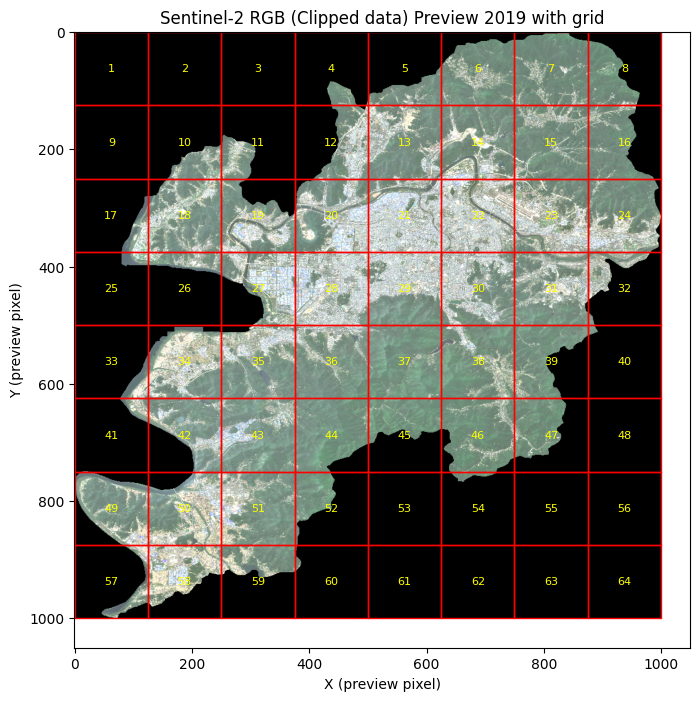

In [20]:
#Load satellite band data as arrays
grid_n = 8 #
scale = 1000 #means: resample to 1000x1000

with rasterio.open(data_bands_2019["B04"]) as r: R2019_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2019["B03"]) as r: G2019_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2019["B02"]) as r: B2019_f = r.read(1, out_shape=(scale, scale))

#qstretch (builded function before)
#Merge into RGB image
rgb = np.dstack([qstretch(R2019_f), qstretch(G2019_f), qstretch(B2019_f)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

# grid marker
h, w = rgb.shape[:2]
step_x = w // grid_n
step_y = h // grid_n

index = 1
for i in range(grid_n):
    for j in range(grid_n):
        x0, x1 = j*step_x, (j+1)*step_x
        y0, y1 = i*step_y, (i+1)*step_y
        ax.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0],'r-',lw=1)
        ax.text(x0+step_x/2, y0+step_y/2, str(index),
                color='yellow', ha='center', va='center', fontsize=8)
        index += 1

plt.title("Sentinel-2 RGB (Clipped data) Preview 2019 add grid")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2019/Sentinel2_preview_2019_clipped_grid",
            dpi=300, bbox_inches='tight')
plt.show()

Saving done: ['/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B02_10m_2019_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B03_10m_2019_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B04_10m_2019_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B08_10m_2019_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B11_10m_2019_grid58.tif']


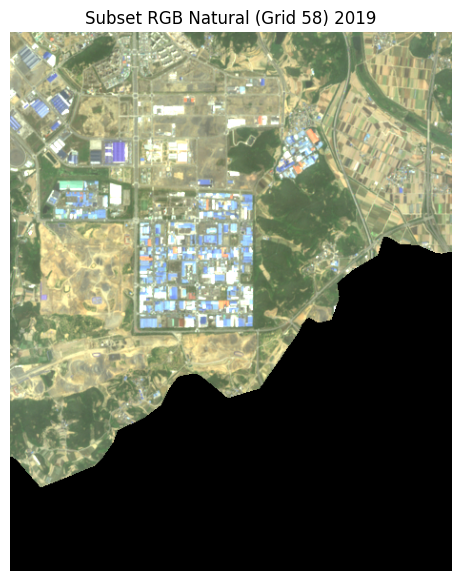

In [30]:
ref = rasterio.open(data_bands_2019["B08"])
bounds = ref.bounds

#extract specific tiles
def crop_by_index(idx, grid_n=5):
    row = (idx-1)//grid_n #
    col = (idx-1)%grid_n

    x0 = bounds.left   + (bounds.right-bounds.left) * (col   /grid_n)
    x1 = bounds.left   + (bounds.right-bounds.left) * ((col+1)/grid_n)
    y0 = bounds.top    - (bounds.top-bounds.bottom) * ((row+1)/grid_n)
    y1 = bounds.top    - (bounds.top-bounds.bottom) * (row   /grid_n)
    bbox = (x0, y0, x1, y1)

    #crop each band
    outputs = []
    subset_bands = {}
    for k, v in data_bands_2019.items():
        if v is None:
            continue
        with rasterio.open(v) as src:
            win = from_bounds(*bbox, src.transform)
            arr = src.read(1, window=win)
            transform = src.window_transform(win)
            meta = src.meta.copy()
            meta.update({"height": arr.shape[0], "width": arr.shape[1], "transform": transform})
            out_path = os.path.join(Save_dir, os.path.basename(v).replace(".tif", f"_grid{idx}.tif"))
            with rasterio.open(out_path, "w", **meta) as dst:
                dst.write(arr, 1)
            outputs.append(out_path)
            subset_bands[k] = arr

    print("Saving done:", outputs)

    # true colour
    if all(b in subset_bands for b in ["B04","B03","B02"]):
        disp = np.dstack([
            qstretch(subset_bands["B04"]),
            qstretch(subset_bands["B03"]),
            qstretch(subset_bands["B02"])
        ])
        plt.figure(figsize=(7,7))
        plt.imshow(disp, origin="upper")
        plt.title(f"Subset RGB Natural (Grid {idx}) 2019")
        plt.axis("off")
        plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2019/selected_grid",
            dpi=300, bbox_inches='tight')
        plt.show()

    return outputs, subset_bands, bbox

idx = 14
outputs, subset_bands, bbox = crop_by_index(idx, grid_n)

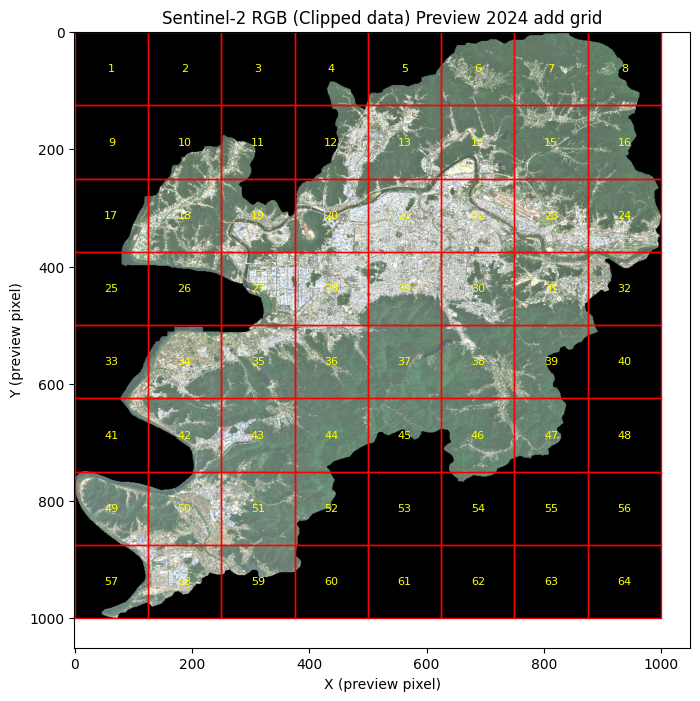

In [32]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(data_bands_2024["B04"]) as r: R2024_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2024["B03"]) as r: G2024_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2024["B02"]) as r: B2024_f = r.read(1, out_shape=(scale, scale))

#Merge into RGB image
rgb = np.dstack([qstretch(R2024_f), qstretch(G2024_f), qstretch(B2024_f)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

# grid marker
h, w = rgb.shape[:2]
step_x = w // grid_n
step_y = h // grid_n

index = 1
for i in range(grid_n):
    for j in range(grid_n):
        x0, x1 = j*step_x, (j+1)*step_x
        y0, y1 = i*step_y, (i+1)*step_y
        ax.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0],'r-',lw=1)
        ax.text(x0+step_x/2, y0+step_y/2, str(index),
                color='yellow', ha='center', va='center', fontsize=8)
        index += 1

plt.title("Sentinel-2 RGB (Clipped data) Preview 2024 add grid")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2024/Sentinel2_preview_2024_clipped_grid",
            dpi=300, bbox_inches='tight')
plt.show()

Saving done: ['/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B02_10m_2024_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B03_10m_2024_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B04_10m_2024_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B08_10m_2024_grid58.tif', '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix/subset_grid/B11_10m_2024_grid58.tif']


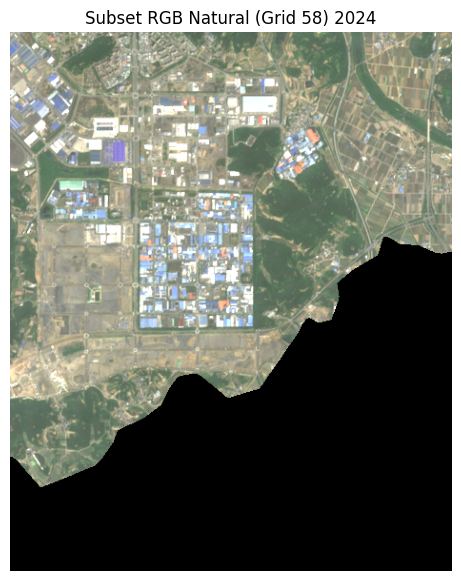

In [33]:
ref = rasterio.open(data_bands_2024["B08"])
bounds = ref.bounds

#extract specific tiles
def crop_by_index(idx, grid_n=5):
    row = (idx-1)//grid_n #
    col = (idx-1)%grid_n

    x0 = bounds.left   + (bounds.right-bounds.left) * (col   /grid_n)
    x1 = bounds.left   + (bounds.right-bounds.left) * ((col+1)/grid_n)
    y0 = bounds.top    - (bounds.top-bounds.bottom) * ((row+1)/grid_n)
    y1 = bounds.top    - (bounds.top-bounds.bottom) * (row   /grid_n)
    bbox = (x0, y0, x1, y1)

    #crop each band
    outputs = []
    subset_bands = {}
    for k, v in data_bands_2024.items():
        if v is None:
            continue
        with rasterio.open(v) as src:
            win = from_bounds(*bbox, src.transform)
            arr = src.read(1, window=win)
            transform = src.window_transform(win)
            meta = src.meta.copy()
            meta.update({"height": arr.shape[0], "width": arr.shape[1], "transform": transform})
            out_path = os.path.join(Save_dir, os.path.basename(v).replace(".tif", f"_grid{idx}.tif"))
            with rasterio.open(out_path, "w", **meta) as dst:
                dst.write(arr, 1)
            outputs.append(out_path)
            subset_bands[k] = arr

    print("Saving done:", outputs)

    # true colour
    if all(b in subset_bands for b in ["B04","B03","B02"]):
        disp = np.dstack([
            qstretch(subset_bands["B04"]),
            qstretch(subset_bands["B03"]),
            qstretch(subset_bands["B02"])
        ])
        plt.figure(figsize=(7,7))
        plt.imshow(disp, origin="upper")
        plt.title(f"Subset RGB Natural (Grid {idx}) 2024")
        plt.axis("off")
        plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2024/selected_grid",
            dpi=300, bbox_inches='tight')
        plt.show()

    return outputs, subset_bands, bbox

idx = 58
outputs, subset_bands, bbox = crop_by_index(idx, grid_n)